# Polygon workaround

- **Idea**: Building a shape vector for each contour point

- **Construction step**:
    1. Pre-processing
        + Load image
        + Load the list of color

    2. Extracting contour
        + Extract contour based on DBz map
        + Reduce the number of vertices using *Douglas-Peucker* algorithm
    
    3. Building shape vector map
        + Build a shape vector for each vertex in the boundary

## I. Load data

In [1]:
import matplotlib.pyplot as plt
from utils import *
import json
import numpy as np
import cv2
import math
from shapely.geometry import Point, Polygon

from shapely.ops import unary_union

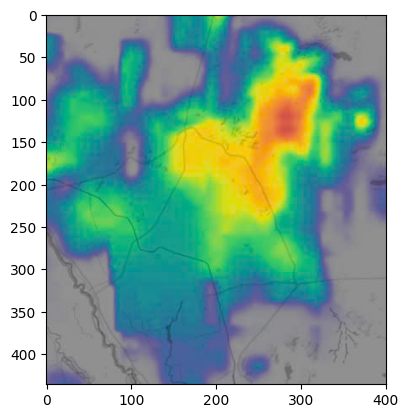

In [2]:
img_path = 'data/image_old/weather_7.jpg'
src_img = plt.imread(img_path)

plt.imshow(src_img)
plt.show()

In [5]:
with open('data/legend/color_dbz.json') as f:
    list_color = json.load(f)

sorted_color = sorted({tuple(color[1]): color[0] for color in list_color}.items(), key=lambda item: item[1])
sorted_color[:3]

[((130, 130, 130), 0), ((123, 121, 132), 3), ((95, 85, 141), 8)]

## 2. Extract contours

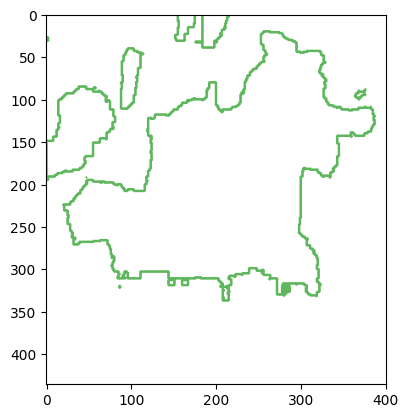

In [6]:
contours_img, contours, colors  = extract_contour_by_dbz(src_img, thresholds=[20], sorted_color=sorted_color)

plt.imshow(contours_img)
plt.show()

Epsilon = 10.937827951184097
Number of vertices = 30


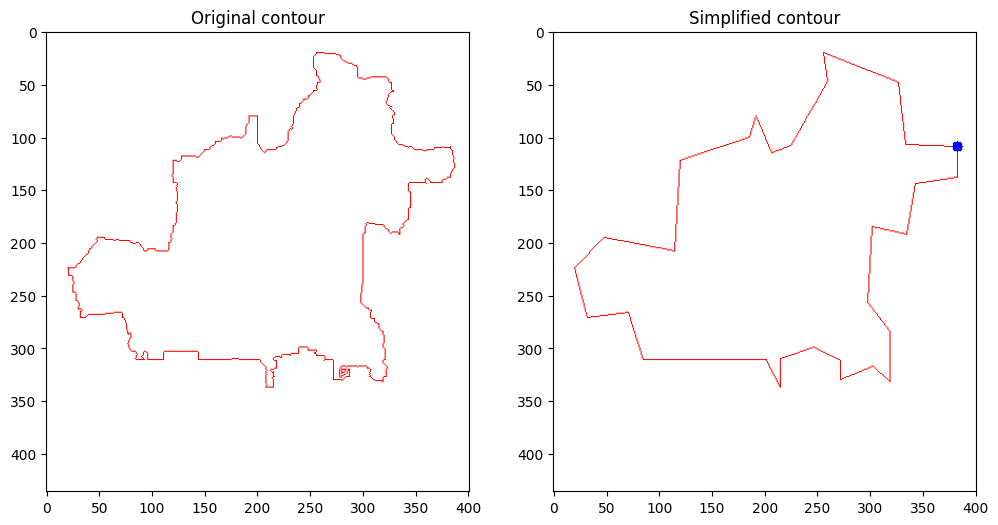

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

In [7]:
contour = sorted([polygon for polygon in contours[0]], key=lambda x: cv2.contourArea(x), reverse=True)[0]

epsilon = math.log(cv2.contourArea(contour))

print(f"Epsilon = {epsilon}")

simplified_contour = cv2.approxPolyDP(contour, epsilon, True)
print(f"Number of vertices = {len(simplified_contour)}")

point_A = simplified_contour[0][0]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left: simplified contour
plot_contour(contour, shape=src_img.shape, ax=axes[0], color=(255, 0, 0), thickness=1)
axes[0].set_title("Original contour")

# Right: contour + point A
blank_img = np.ones(shape=src_img.shape, dtype=np.uint8) * 255
plot_contour(simplified_contour, shape=src_img.shape, ax=axes[1], color=(255, 0, 0), thickness=1, blank_img=blank_img)

cv2.circle(blank_img, tuple(point_A), 5, (0, 0, 255), -1)  # draw point A
axes[1].imshow(blank_img)
axes[1].set_title("Simplified contour")

plt.show()

## 3. Build vector map for each point in contours

Radius: 20
	0.00	0.00	157.06	157.06	8.16	0.00	0.00	0.00	
Radius: 40
	0.00	0.00	311.44	471.18	24.47	0.00	0.00	0.00	


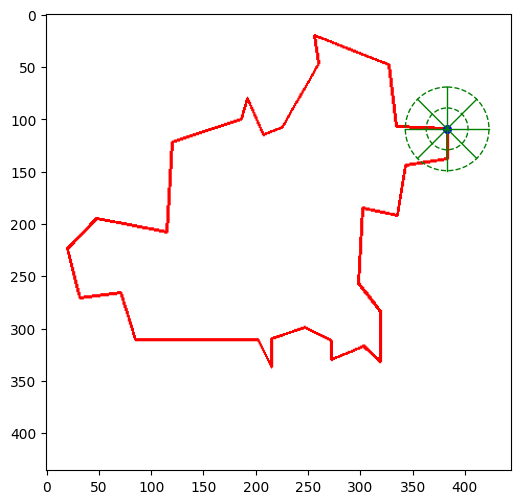

In [8]:
def plot_shape_vector(contours, point_A, radii = [20, 40, 60], num_sectors = 8):
    _, ax = plt.subplots(figsize=(6, 6))

    blank_img = np.ones_like(src_img, dtype=np.int16) * 255

    # Plot polygon (assuming you have a helper function plot_contour)
    for contour in contours:
        plot_contour(contour, shape=src_img.shape, new_fig=False, blank_img=blank_img)

    # Add circles
    for r in radii:
        circle = plt.Circle(point_A, radius=r, color='green', fill=False, linestyle="--")
        ax.add_patch(circle)

    # Add radial lines (sectors)
    longest_r = max(radii)
    for i in range(num_sectors):
        grad_angle = np.deg2rad(i * (360 / num_sectors))
        x_start, y_start = point_A
        x_end = x_start + np.cos(grad_angle) * longest_r
        y_end = y_start + np.sin(grad_angle) * longest_r
        ax.plot([x_start, x_end], [y_start, y_end], color="green", linewidth=1)

    # Mark the reference point
    ax.scatter([point_A[0]], [point_A[1]], marker='o', s=30, color="blue", label="Point A")

    ax.set_aspect("equal", adjustable="box")
    plt.show()

radii = [20, 40]
num_sectors = 8

features_vector = construct_shape_vector([simplified_contour], point_A, radii=radii, num_sectors=num_sectors)

for r in range(len(radii)):
    print(f"Radius: {radii[r]}", end="\n\t")
    for s in range(num_sectors):
        print(f"{features_vector[r * num_sectors + s]:.2f}", end="\t")
    
    print("")

plot_shape_vector([simplified_contour], point_A, radii=radii, num_sectors=num_sectors)

## 3. Extract a global set of keypoints of weather image

In [9]:
simplified_contour_list = []
for contour in contours[0]:
    area = cv2.contourArea(contour)
    if area > 0:
        epsilon = math.log(cv2.contourArea(contour))
    else:
        print(f"Error at {contour}")
        continue

    # print(f"Epsilon = {epsilon}")

    simplified_contour = cv2.approxPolyDP(contour, epsilon, True)
    print(f"Number of vertices before simplified = {len(contour)}")
    print(f"Number of vertices after simplified = {len(simplified_contour)}")
    print(f"---")

    if len(simplified_contour) <= 2:
        continue
    simplified_contour_list.append(simplified_contour)

Number of vertices before simplified = 4
Number of vertices after simplified = 4
---
Number of vertices before simplified = 4
Number of vertices after simplified = 4
---
Number of vertices before simplified = 4
Number of vertices after simplified = 4
---
Number of vertices before simplified = 4
Number of vertices after simplified = 4
---
Error at [[[ 47 192]]]
Number of vertices before simplified = 20
Number of vertices after simplified = 4
---
Number of vertices before simplified = 120
Number of vertices after simplified = 6
---
Number of vertices before simplified = 59
Number of vertices after simplified = 5
---
Number of vertices before simplified = 5
Number of vertices after simplified = 2
---
Number of vertices before simplified = 597
Number of vertices after simplified = 30
---
Number of vertices before simplified = 37
Number of vertices after simplified = 5
---
Number of vertices before simplified = 21
Number of vertices after simplified = 4
---


In [10]:
points = [point for contour in simplified_contour_list for point in contour.squeeze(1)]

point_features = []
radii = [20, 40, 60, 80]
num_sectors = 12

for point in points:
    try:
        point_features.append((
            point, 
            construct_shape_vector(simplified_contour_list, point, radii=radii, num_sectors=num_sectors)
        ))
    except:
        pass

len(points), len(point_features)

(70, 70)

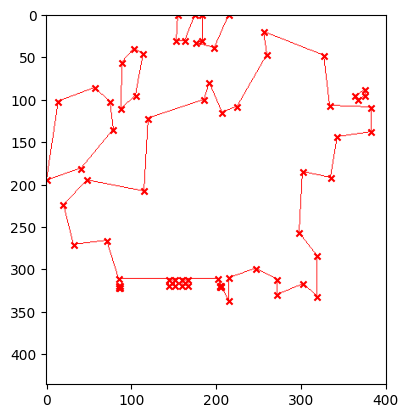

In [11]:
blank_img = np.ones_like(src_img, np.int16) * 255
cv2.drawContours(blank_img, simplified_contour_list, contourIdx=-1, color=(255, 0, 0), thickness=1)
plt.imshow(blank_img)

for point in points:
    plt.scatter(point[0], point[1], s=20, c='red', marker='x')

plt.show()

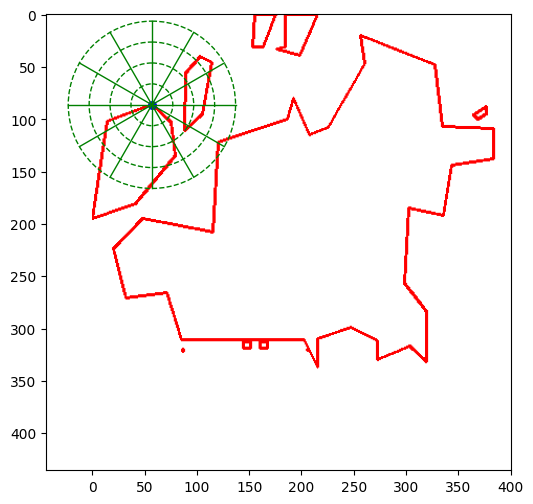

In [12]:
plot_shape_vector(simplified_contour_list, points[20], radii=radii, num_sectors=num_sectors)
plt.show()